In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm



from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)
from pathlib import Path
import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl

from src.config import ExtractConfig
from src.llms.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.llms.phi.model_phi import PhiForCausalLMWHS
from src.eval.ds import filter_ds_to_known
from src.datasets.act_dm import ActivationDataModule

# plt.style.use("ggplot")
# plt.style.use("seaborn-v0_8")
import seaborn as sns
sns.set_theme('paper')


## Paramsnet


In [65]:
# params

# cfg = ExtractConfig(
#     # model="microsoft/phi-2",
#     # # batch_size=1,
#     # prompt_format="phi",
# )
# cfg

# params
batch_size = 32
lr = 4e-3
wd = 1e-5

MAX_ROWS = 2000

SKIP=5 # skip initial N layers
STRIDE=4 # skip every N layers
DECIMATE=12 # discard N features for speed

device = "cuda:0"
max_epochs = 44

VAE_EPOCH_MULT = 25
l1_coeff = 1.0e-4  # neel uses 3e-4 ! https://github.dev/neelnanda-io/1L-Sparse-Autoencoder/blob/bcae01328a2f41d24bd4a9160828f2fc22737f75/utils.py#L106, but them they sum l1 where mean l2
    # x_feats=x_feats. other use 1e-1


BASE_FOLDER = Path("/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/")
layers_names = ('fc1', 'Wqkv', 'fc2', 'out_proj')

## Load data

In [3]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
# FROM TRAINING TRUTH
f1_val = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_valtest_*')))
f1_ood = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_OOD_*')))
f1_val, f1_ood

(PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/hidden_states/.ds/ds_valtest_8b8fd6070504d5ef'),
 PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/hidden_states/.ds/ds_OOD_a41d3a61513ade30'))

In [4]:
# insample_datasets = list(set(ds_val['ds_string_base']))
# outsample_datasets = list(set(ds_ood['ds_string_base']))
# print(insample_datasets, outsample_datasets)

In [5]:
input_columns = ['binary_ans_base', 'binary_ans_adapt' ] + [f'end_residual_{layer}_base' for layer in layers_names] + [f'end_residual_{layer}_adapt' for layer in layers_names]

def ds2xy_batched(ds):
    data = []
    for layer in layers_names:
        # Stack the base and adapter representations as a 4th dim
        X1 = [ds[f'end_residual_{layer}_base'], ds[f'end_residual_{layer}_adapt']]
        X1 = rearrange(X1, 'versions b l f  -> b l f versions')
        data.append(X1)
    
    # concat layers
    # x = rearrange(data, 'b parts l f v -> b l (parts f) v')
    X = torch.concat(data, dim=2)[:, SKIP::STRIDE, ::DECIMATE]

    y = ds['binary_ans_base']-ds['binary_ans_adapt']
    return dict(X=X, y=y)



def prepare_ds(ds):
    """
    prepare a dataset for training

    this should front load much of the computation
    it should restrict it to the needed rows X and y
    
    """
    ds = (ds
          .with_format("torch")
          .select_columns(input_columns)
          .map(ds2xy_batched, batched=True, batch_size=128,
        remove_columns=input_columns)
    )
    return ds

def load_file_to_dm(f):
    ds = Dataset.from_file(str(f1_val), in_memory=True).with_format("torch")
    ds = filter_ds_to_known(ds, verbose=True, true_col='truth')
    ds = prepare_ds(ds)

    # limit size
    MAX_SAMPLES = min(len(ds), MAX_ROWS*2)
    ds = ds.select(range(0, MAX_SAMPLES))

    dm = ActivationDataModule(ds, f.stem, batch_size=batch_size, num_workers=4)
    dm.setup()
    return dm




In [6]:
dm = load_file_to_dm(f1_val)
dm_ood = load_file_to_dm(f1_ood)

select rows are 74.39% based on knowledge


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

select rows are 74.39% based on knowledge


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

In [13]:
# slow... takes 12 mins. It's the accessing
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
dl_test = dm.test_dataloader()
dl_ood = dm_ood.all_dataloader()

making shared dataset with unique name ds_valtest_8b8fd6070504d5ef_train
making shared dataset with unique name ds_valtest_8b8fd6070504d5ef_val
making shared dataset with unique name ds_valtest_8b8fd6070504d5ef_test
making shared dataset with unique name ds_OOD_a41d3a61513ade30_all


Experiment with dataloading speeds:
- does it help to save the Xy dataset to disc, then load, while keeping in mem?. no not faster at all
- does it help to use num_workers > 0? yes 3x faster
- the shared dataset wrapper is 10x faster, and less mem

# Get importance matrix from adapter

Wqkv torch.Size([32, 7680])
out_proj torch.Size([32, 2560])
fc1 torch.Size([32, 10240])
fc2 torch.Size([32, 2560])


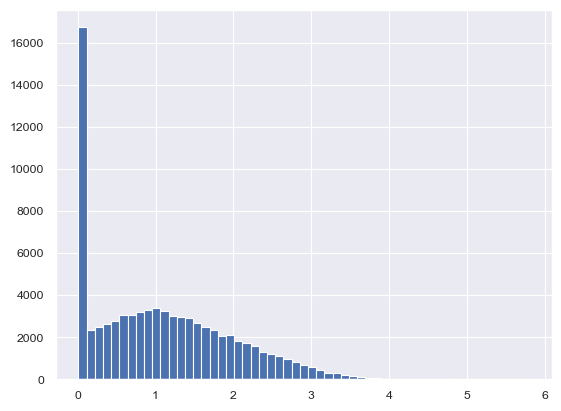

In [7]:
from src.probes.importance_matrix import get_importance_matrix


f = f"{BASE_FOLDER}/checkpoint_last/adapter_model.safetensors"
importance_matrix = get_importance_matrix(f, layers=layers_names)[SKIP::STRIDE, ::DECIMATE]
plt.hist(importance_matrix.flatten(), bins=55);


In [8]:
ds_test2 = dm.datasets['test']
shape1 = ds_test2[0]['X'][:, :, 0].shape
shape2= importance_matrix.shape
np.testing.assert_equal(shape1, shape2, err_msg="shape mismatch between ds and importance matrix")


# Model

In [41]:
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

from torch import dropout
from src.probes.pl_ranking_probe import InceptionBlock, LinBnDrop, ConvBlock


class Encoder(nn.Module):
    def __init__(self, n_layers, n_channels, hs, c_out, ks=[7, 5, 3], dropout=0):
        super().__init__()
        self.n_layers = n_layers

        self.conv = nn.Sequential(
            # nn.BatchNorm1d(n_channels, affine=False),
            InceptionBlock(n_channels, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks),
            InceptionBlock(hs * 4, hs, ks=ks),
        )

        self.fc = nn.Sequential(
            LinBnDrop(hs * 4 * n_layers, c_out * n_layers, dropout=dropout),
            nn.Linear(c_out * n_layers, c_out * n_layers),
        )

    def forward(self, x):
        x = self.conv(x)
        x = rearrange(x, "b c l -> b (c l)")
        x = self.fc(x)
        x = rearrange(x, "b (c l) -> b c l", l=self.n_layers)
        return x


class Decoder(nn.Module):
    def __init__(self, n_latent, n_layers, hs, c_out=1, ks=[7, 5, 3], dropout=0):
        super().__init__()
        hs = hs * 2
        self.layers = n_layers

        self.fc = nn.Sequential(
            # nn.BatchNorm1d(
            #     n_latent * n_layers, affine=False
            # ),  # center it, regularize it
            LinBnDrop(n_latent * n_layers, hs * n_layers, dropout=dropout),
            nn.ReLU(),
        )

        self.conv = nn.Sequential(
            InceptionBlock(hs, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks, coord=True),
            InceptionBlock(hs * 4, hs, ks=ks),
            nn.Conv1d(hs * 4, c_out, 1),
        )

    def forward(self, x):
        x = rearrange(x, "b l c -> b (l c)")
        x = self.fc(x)
        x = rearrange(x, "b (c l) -> b c l", l=self.layers)
        x = self.conv(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(
        self, c_in, depth=3, n_hidden=32, n_latent=32, l1_coeff: float = 1.0, dropout=0, importance_matrix=None
    ):
        super().__init__()
        self.l1_coeff = l1_coeff
        self.importance_matrix = importance_matrix
        n_layers, n_channels = c_in
        self.enc = Encoder(n_layers, n_channels, n_hidden, n_latent, dropout=dropout)
        self.dec = Decoder(
            n_latent, n_layers, n_hidden // 4, c_out=n_channels, dropout=dropout
        )
    #     self.apply_weight_norm(self.dec)
    #     self.apply_weight_norm(self.enc)

    # def apply_weight_norm(self, net):
    #     for m in net.modules():
    #         if isinstance(m, nn.Conv1d):
    #             # I think it's 1. In the example they use 2, but their weights are transposed before use
    #             torch.nn.utils.parametrizations.weight_norm(m, dim=1)

    def forward(self, h: Float[Tensor, "batch_size n_hidden n_channels"]):
        device = next(self.parameters()).device
        h = h.to(device)
        latent = self.enc(h)
        h_rec = self.dec(latent)

        if self.importance_matrix is None:
            importance_matrix = torch.ones_like(h_rec)
            1/0
        else:
            importance_matrix = self.importance_matrix.to(device).T[None]

        # Compute loss, return values
        l2_loss = (
            ((h_rec - h) * importance_matrix).pow(2).mean(-1).mean(1)
        )  # shape [batch_size sum(neurons) mean(layers)] - punish the model for not reconstructing the input
        l1_loss = (
            latent.abs().sum(-1).sum(1)
        )  # shape [batch_size sum(latent) sum(layers)] - punish the model for large latent values
        loss = (self.l1_coeff * l1_loss + l2_loss).mean(0)  # scalar

        return l1_loss, l2_loss, loss, latent, h_rec


In [76]:
def recursive_requires_grad(model, mode: bool = False):
    print(f"requires_grad: {mode}")
    for param in model.parameters():
        param.requires_grad = mode


In [77]:
from src.probes.pl_base import PLBase
from torchmetrics.functional import accuracy, auroc


class PLAE(PLBase):
    def __init__(
        self,
        c_in,
        epoch_steps,
        max_epochs,
        depth=0,
        lr=4e-3,
        weight_decay=1e-9,
        hs=64,
        n_latent=32,
        l1_coeff=1,
        dropout=0,
        importance_matrix=None,
        **kwargs,
    ):
        super().__init__(epoch_steps=epoch_steps, max_epochs=max_epochs, lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()

        self.ae = AutoEncoder(
            c_in,
            n_hidden=hs,
            n_latent=n_latent,
            depth=depth,
            l1_coeff=l1_coeff,
            dropout=dropout,
            importance_matrix=importance_matrix
        )
        n_layers, n_channels = c_in
        n = n_latent * n_layers
        self.head = nn.Sequential(
            LinBnDrop(n, n, bn=False),
            LinBnDrop(n, n // 4, dropout=dropout, bn=False),
            LinBnDrop(n // 4, n // 12, bn=False),
            nn.Linear(n // 12, 1),
            # nn.Tanh(),
        )
        self._ae_mode = True

    def ae_mode(self, mode=0):
        """
        mode 0, train the ae
        mode 1, train only the prob
        mode 2, train both
        """
        if mode==0:
            print('training ae')
        elif mode==1:
            print('training probe')
        elif mode==2:
            print('training both ae and probe')
        self._ae_mode = mode
        recursive_requires_grad(self.ae, mode in [0, 2])

    def forward(self, x):
        if x.ndim == 4:
            x = x.squeeze(3)
        x = rearrange(x, "b l h -> b h l")
        # if not self._ae_mode:
        #     with torch.no_grad():
        #         l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)
        # else:
        l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)

        latent2 = rearrange(latent, "b l h -> b (l h)")
        pred = self.head(latent2).squeeze(1)
        return dict(
            pred=pred,
            l1_loss=l1_loss,
            l2_loss=l2_loss,
            loss=loss,
            latent=latent,
            h_rec=h_rec,
        )

    def _step(self, batch, batch_idx, stage="train"):
        # if stage=='train':
        #     # Normalize the decoder weights before each optimization step (from https://colab.research.google.com/drive/1rPy82rL3iZzy2_Rd3F82RwFhlVnnroIh?usp=sharing#scrollTo=q1JctT2Pvw-r)
        #     # Presumably this is a way to implement weight norm to regularize the decoder
        #     self.normalize_decoder()
        device = next(self.parameters()).device
        x, y = batch # batch['X'], batch['y']
        x = x.to(device)
        y = y.to(device)
        x0 = x[..., 0]
        # x1 = x[..., 1]
        info0 = self(x0)
        # info1 = self(x1)
        # ypred1 = info1["pred"]
        logits = info0["pred"]
        y_probs = F.sigmoid(logits)
        y_cls = y_probs > 0.5

        if stage == "pred":
            return (y_probs).float()
        
        pred_loss = F.binary_cross_entropy_with_logits(logits, (y>0.).float())

        # pred_loss = F.smooth_l1_loss(ypred0, y)
        rec_loss = info0["loss"] 
        l1_loss = info0["l1_loss"].mean()
        l2_loss = info0["l2_loss"].mean()

        self.log(
            f"{stage}/auroc",
            auroc(y_probs, y > 0, "binary"),
            on_epoch=True,
            on_step=False,
        )
        self.log(
            f"{stage}/acc",
            accuracy(y_cls, y > 0, "binary"),
            on_epoch=True,
            on_step=False,
        )
        self.log(
            f"{stage}/loss_pred",
            float(pred_loss),
            on_epoch=True,
            on_step=True,
            prog_bar=True,
        )
        self.log(
            f"{stage}/loss_rec",
            float(rec_loss),
            on_epoch=True,
            on_step=True,
            prog_bar=True,
        )
        self.log(f"{stage}/l1_loss", l1_loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/l2_loss", l2_loss, on_epoch=True, on_step=False)
        self.log(
            f"{stage}/n",
            float(len(y)),
            on_epoch=True,
            on_step=False,
            reduce_fx=torch.sum,
        )
        if self._ae_mode == 0:
            assert torch.isfinite(rec_loss), "rec_loss is not finite"
            return rec_loss
        elif self._ae_mode == 1:
            assert torch.isfinite(pred_loss), "pred_loss is not finite"
            return pred_loss
        elif self._ae_mode == 2:
            # , train/loss_pred_epoch=0.0195, train/loss_rec_epoch=169.0
            assert torch.isfinite(pred_loss), "pred_loss is not finite"
            assert torch.isfinite(rec_loss), "rec_loss is not finite"
            return pred_loss * 50000 + rec_loss


# Train

### Metrics


In [78]:
def get_acc_subset(df, query, verbose=True):
    if query:
        df = df.query(query)
    acc = (df["probe_pred"] == df["y"]).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc


def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits["test"]
    df_test = dm.df.iloc[splits[0] : splits[1]].copy()
    df_test["probe_pred"] = y_test_pred > 0.0

    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits["val"]
        df_val = dm.df.iloc[splits[0] : splits[1]].copy()
        df_val["probe_pred"] = y_val_pred > 0.0

        df_test = pd.concat([df_val, df_test])

    if verbose:
        print("probe results on subsets of the data")
    acc = get_acc_subset(df_test, "", verbose=verbose)
    get_acc_subset(
        df_test, "instructed_to_lie==True", verbose=verbose
    )  # it was ph told to lie
    get_acc_subset(
        df_test, "instructed_to_lie==False", verbose=verbose
    )  # it was told not to lie
    get_acc_subset(
        df_test, "llm_ans==label_true", verbose=verbose
    )  # the llm gave the true ans
    get_acc_subset(
        df_test, "llm_ans==label_instructed", verbose=verbose
    )  # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=verbose
    )  # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=verbose
    )

    a = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans==label_instructed", verbose=False
    )
    b = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans!=label_instructed", verbose=False
    )
    c = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=False
    )
    d = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=False
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["instructed_to_lie==False", "instructed_to_lie==True"],
        columns=["llm_ans==label_instructed", "llm_ans!=label_instructed"],
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["tell a truth", "tell a lie"],
        columns=["did", "didn't"],
    )
    d1.index.name = "instructed to"
    d1.columns.name = "llm gave"
    print("probe accuracy for quadrants")
    display(d1.round(2))

    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)

### Setup

In [79]:


print(len(dl_train), len(dl_val))
b = next(iter(dl_train))
x, y = b # b['X'], b['y']
print(x.shape, "x")
if x.ndim == 3:
    x = x.unsqueeze(-1)
c_in = x.shape[1:-1]


10 5


torch.Size([32, 7, 11520, 2]) x


In [80]:
# # TEST
# for b in tqdm(dl_train):
#     pass

In [81]:
# %%time
# # oh no, this is very slow
# g = iter(dl_train)
# b = next(g)
# b = next(g)


In [86]:

net = PLAE(
    c_in=c_in,
    epoch_steps=max_epochs,
    max_epochs=max_epochs * VAE_EPOCH_MULT,
    lr=lr,
    weight_decay=wd,
    hs=128,
    depth=3,
    # dropout=0.05,
    dropout=1,
    n_latent=64,
    l1_coeff=l1_coeff, 
    importance_matrix=importance_matrix,
)
print(c_in)
x1= x[..., 0]
with torch.no_grad():
    y = net(x1)
{k: v.abs().mean() for k, v in y.items()}

torch.Size([7, 11520])


{'pred': tensor(0.0679),
 'l1_loss': tensor(10.1619),
 'l2_loss': tensor(321.7482),
 'loss': tensor(321.7493),
 'latent': tensor(0.0227),
 'h_rec': tensor(0.3759)}

In [87]:
from torchinfo import summary

summary(net, input_data=x1, depth=4)  # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                                  Output Shape              Param #
PLAE                                                    [32, 11520, 7]            --
├─AutoEncoder: 1-1                                      [32]                      --
│    └─Encoder: 2-1                                     [32, 64, 7]               --
│    │    └─Sequential: 3-1                             [32, 512, 7]              --
│    │    │    └─InceptionBlock: 4-1                    [32, 512, 7]              3,199,360
│    │    │    └─InceptionBlock: 4-2                    [32, 512, 7]              381,312
│    │    │    └─InceptionBlock: 4-3                    [32, 512, 7]              381,312
│    │    │    └─InceptionBlock: 4-4                    [32, 512, 7]              381,312
│    │    │    └─InceptionBlock: 4-5                    [32, 512, 7]              381,312
│    │    └─Sequential: 3-2                             [32, 448]                 --
│    │    │    └─LinBnDrop: 4-6  

### Train autoencoder

In [88]:
torch.set_float32_matmul_precision('medium')

In [89]:
net.ae_mode(0)
trainer1 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    # devices=2,
    accelerator="auto",
    devices="1",
    max_epochs=max_epochs * VAE_EPOCH_MULT,
    log_every_n_steps=1,
    # enable_progress_bar=False, enable_model_summary=False
)

LOAD_CHECKPONT = Path('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
if LOAD_CHECKPONT:
    net.load_from_checkpoint(LOAD_CHECKPONT)
else:
    trainer1.fit(model=net, train_dataloaders=dl_train, 
                #  val_dataloaders=dl_val # FIXME why does this slow it down with multiple processes?
                );


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 10.1 M
1 | head | Sequential  | 255 K 
-------------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params
41.232    Total estimated model params size (MB)


training ae
requires_grad: True


Training: |          | 0/? [00:00<?, ?it/s]

5/10 [00:04<00:04, 1.10it/s, v_num=295, val/loss_pred=0.0849, val/loss_rec=9.58e+5, train/loss_pred=0.350, train/loss_rec=9.8e+5]


In [90]:
from src.helpers.lightning import read_metrics_csv, plot_hist, rename_pl_test_results


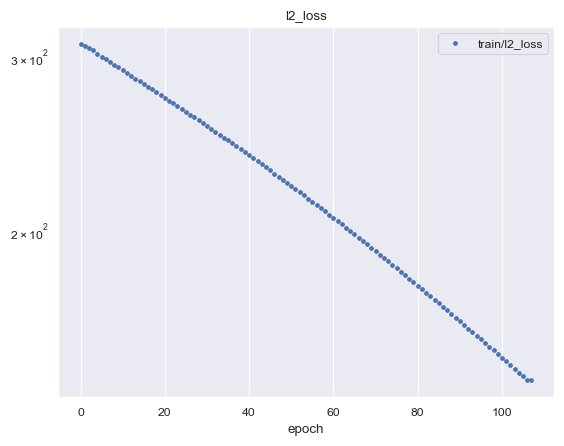

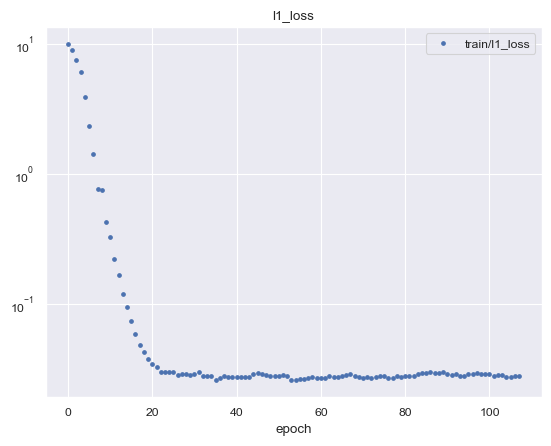

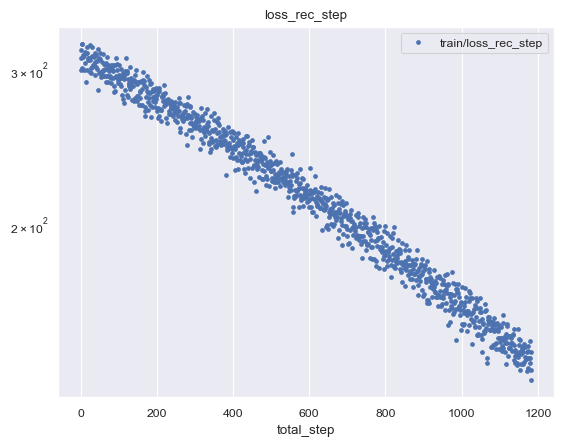

,train/loss_pred_step,train/loss_rec_step,step,train/loss_pred_epoch,train/n,train/auroc,train/acc,train/l2_loss,train/loss_rec_epoch,train/l1_loss
epoch,,,,,,,,,,
0,0.684778,310.745544,9,0.685872,307.0,0.5,0.615635,309.231293,309.232269,10.014018
1,0.684737,308.330994,19,0.685851,307.0,0.5,0.615635,307.649139,307.650085,8.961210
2,0.673843,317.790558,29,0.685804,307.0,0.5,0.615635,306.125702,306.126465,7.549841
3,0.688270,306.254486,39,0.685762,307.0,0.5,0.615635,304.672424,304.673035,6.062644
4,0.684548,293.770813,49,0.685695,307.0,0.5,0.615635,302.540924,302.541321,3.956732
...,...,...,...,...,...,...,...,...,...,...
103,0.695597,142.856110,1039,0.685676,307.0,0.5,0.615635,145.086716,145.086716,0.028288
104,0.691918,136.771362,1049,0.685674,307.0,0.5,0.615635,143.822296,143.822296,0.027701
105,0.680874,146.126099,1059,0.685674,307.0,0.5,0.615635,142.581390,142.581390,0.027532


In [91]:

df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['l2_loss', 'l1_loss', 'loss_rec'], logy=True)
plt.show()
plot_hist(df_hist_step, ['loss_rec_step'], logy=True)

df_hist


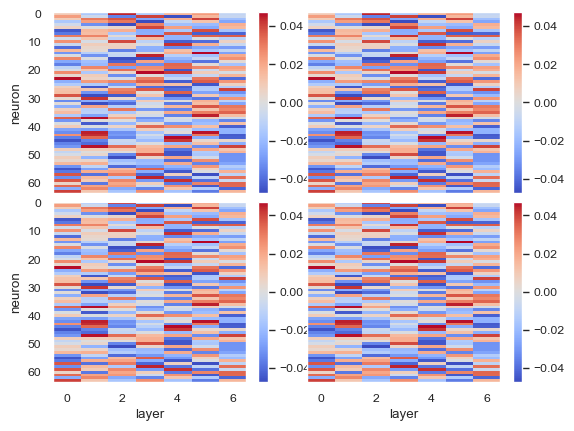

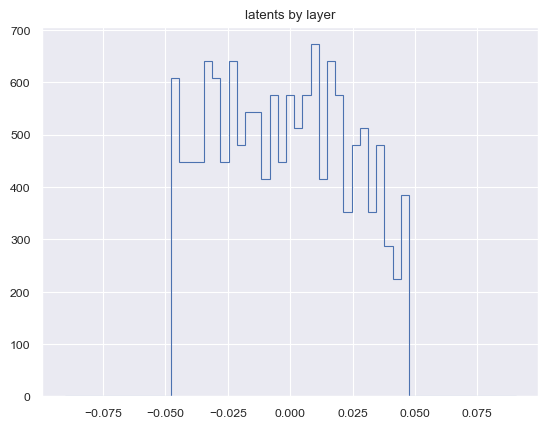

In [92]:
# visualize latent space
from matplotlib import cm


def plot_latent(latent):

    # plot image of latent space
    vmax = latent.abs().max()
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        vmax = latent[i].abs().max()
        plt.imshow(
            latent[i],
            cmap=cm.coolwarm,
            interpolation="none",
            aspect="auto",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xlabel("layer")
        plt.ylabel("neuron")
        if i < 2:
            plt.xlabel("")
            plt.xticks([])
        if i % 2 == 1:
            plt.ylabel("")
            plt.yticks([])
        plt.grid(False)
        plt.colorbar()
    # plt.colorbar()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

    # histogram
    latentf = rearrange(latent, "b n l -> (b n) l").flatten()
    vmax = (latentf.abs().mean() + 5 * latentf.abs().std()).item()
    plt.hist(latentf, bins=55, range=[-vmax, vmax], histtype="step")
    plt.title("latents by layer")
    plt.show()


latent = y["latent"].cpu()  # .reshape(64, 24, 12) # [Batch, Latent, Layer]
plot_latent(latent)


### Train probe

In [110]:
# # net.save_checkpoint
# f = Path(trainer1.log_dir)/"1_ae.ckpt"
# trainer1.save_checkpoint(f)
# # PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
# f

PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')

: 

In [96]:
net.ae_mode(1)
trainer2 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer2.fit(model=net, train_dataloaders=dl_train, 
            #  val_dataloaders=dl_val
             );


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 10.1 M
1 | head | Sequential  | 255 K 
-------------------------------------
255 K     Trainable params
10.1 M    Non-trainable params
10.3 M    Total params
41.232    Total estimated model params size (MB)


training probe
requires_grad: False


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=44` reached.


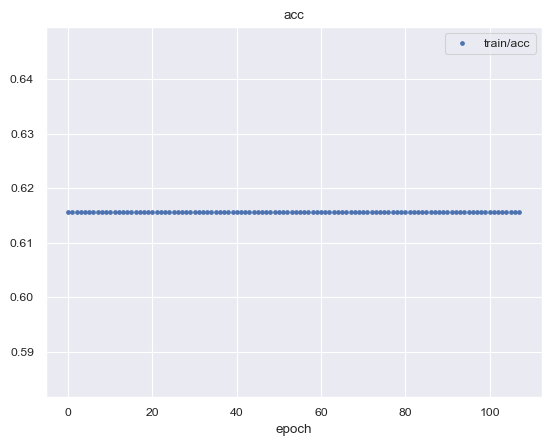

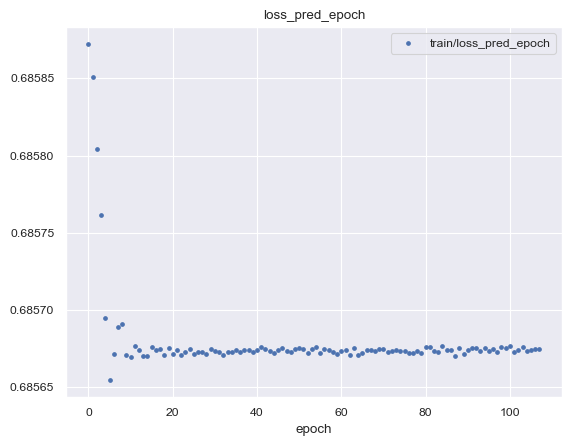

,train/loss_pred_step,train/loss_rec_step,step,train/loss_pred_epoch,train/n,train/auroc,train/acc,train/l2_loss,train/loss_rec_epoch,train/l1_loss
epoch,,,,,,,,,,
0,0.684778,310.745544,9,0.685872,307.0,0.5,0.615635,309.231293,309.232269,10.014018
1,0.684737,308.330994,19,0.685851,307.0,0.5,0.615635,307.649139,307.650085,8.961210
2,0.673843,317.790558,29,0.685804,307.0,0.5,0.615635,306.125702,306.126465,7.549841
3,0.688270,306.254486,39,0.685762,307.0,0.5,0.615635,304.672424,304.673035,6.062644
4,0.684548,293.770813,49,0.685695,307.0,0.5,0.615635,302.540924,302.541321,3.956732
...,...,...,...,...,...,...,...,...,...,...
103,0.695597,142.856110,1039,0.685676,307.0,0.5,0.615635,145.086716,145.086716,0.028288
104,0.691918,136.771362,1049,0.685674,307.0,0.5,0.615635,143.822296,143.822296,0.027701
105,0.680874,146.126099,1059,0.685674,307.0,0.5,0.615635,142.581390,142.581390,0.027532


In [97]:
df_hist, _ = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred_epoch', 'acc'])
df_hist

In [98]:

# predict


# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])




LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

AssertionError: pred_loss is not finite

In [ ]:
testval_metrics = calc_metrics(dm, trainer2, net, use_val=True)
rs = rename_pl_test_results(rs, ["train", "val", "test", "ood"])
# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]

#### how well does it generalize to other datasets?


In [ ]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer1.test(net, dataloaders=[dl_ood])
rs2 = rename_pl_test_results(rs2, ks=["ood"])

testval_metrics2 = calc_metrics(dm_ood, trainer1, net, use_val=True)
rs["ood"]["acc_lie_lie"] = testval_metrics2["acc_lie_lie"]
rs["ood_metrics"] = rs2["ood"]
rs


### Train end-to-end


In [ ]:
net.ae_mode(2)
trainer2 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer2.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
1


In [ ]:
# look at hist
df_hist, _ = read_metrics_csv(trainer2.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred', 'acc'])

# predict
# dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])

testval_metrics = calc_metrics(dm, trainer2, net, use_val=True)
rs = rename_pl_test_results(rs, ["train", "val", "test", "ood"])
# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]


In [ ]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer1.test(net, dataloaders=[dl_ood])
rs2 = rename_pl_test_results(rs2, ks=["ood"])

testval_metrics2 = calc_metrics(dm_ood, trainer1, net, use_val=True)
rs["ood"]["acc_lie_lie"] = testval_metrics2["acc_lie_lie"]
rs["ood_metrics"] = rs2["ood"]
rs
